In [ ]:
 # This is the same code from the previous section, nothing new here.
try:
  # We must install required packages if we are in Google Colab
  import google.colab
  %pip install roboticstoolbox-python>=1.0.2
except:
  # We are not in Google Colab
  # Apply custon style to notebook
  from IPython.core.display import HTML
  import pathlib
  styles_path = pathlib.Path(pathlib.Path().absolute(), "style", "style.css")
  styles = open(styles_path, "r").read()
  HTML(f"<style>{styles}</style>")

In [ ]:
## RUN THIS CODE BLOCK BEFORE STARTING TUTORIAL ##
#import necessary libraries for this specific notebook
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import defaultdict
from numpy import median
import pandas as pd

# 3.0 Resolved-Rate Motion Control

## Table of Contents

### 3.1 Introduction
### 3.2 Resolved-Rate Motion Control
### 3.3 Position Based Servoing
### 3.4 Example



### 3.1 Introduction


In this section of our tutorial, we will cover Resolved Rate-Motion Control (RRMC) and how it enhances the capabilities of robotic manipulation systems. Rate-motion control is a technique used in robotics to precisely control the velocity of a robotic arm's end-effector or individual joints. In this method, the desired end-effector velocities are specified as input commands. The controller then calculates the corresponding joint velocities needed to achieve the end-effector velocities. Recall from part one, the end effector refers to the device or tool attached to the end of a robotic arm.

This tool will be used to move the end-effector in a straight line motion. It allows us to achieve smoother and more dynamic motion, which optimizes trajectory planning for efficiency and respondes quikly to changes in the environment.


### 3.2 Resolved-Rate Motion Control

As previously mentioned, resolved-rate motion control (RRMC) is a simple method used to generate straight-line motion of the end-effector. The equation is defined as,


\begin{align*}
  \dot{q} = J(q)^{-1}\cdot v
\end{align*}

In this formula, $J(q)$ is a square, non-singular matrix of the Jacobian. However, our tutorial is covering the manipulation of a 7 DOF Kinova arm, and therefore will not have a square matrix. Since it is not feasible to invert a non-square matrix, we will instead use the Moore-Penrose pseudoinverse. The formula is represented as,

\begin{align*}
  \dot{q} = J(q)^{+}\cdot v
\end{align*}

This equation expresses the relationship between joint velocities($\dot{q}$)
 and end-effector velocities ($v$), while $J(q)^{+}$ is the pseudo-inverse of the Jacobian matrix.

### 3.3 Position Based Servoing

Position Based Servoing (PBS) is a practical application of RRMC and uses a closed-loop pose controller to enable straight line motion of the end-effector within the robots task space. PBS uses the error vector to accomplish this. The error vector, which will be used extensively in this tutorial, encapsulates the translational and rotational differences between the current and desired end-effector pose. The error vector consists of 6 rows, with the first 3 consisting of the translational error in x, y, z, and the bottom 3 rows representing the rotational errors.

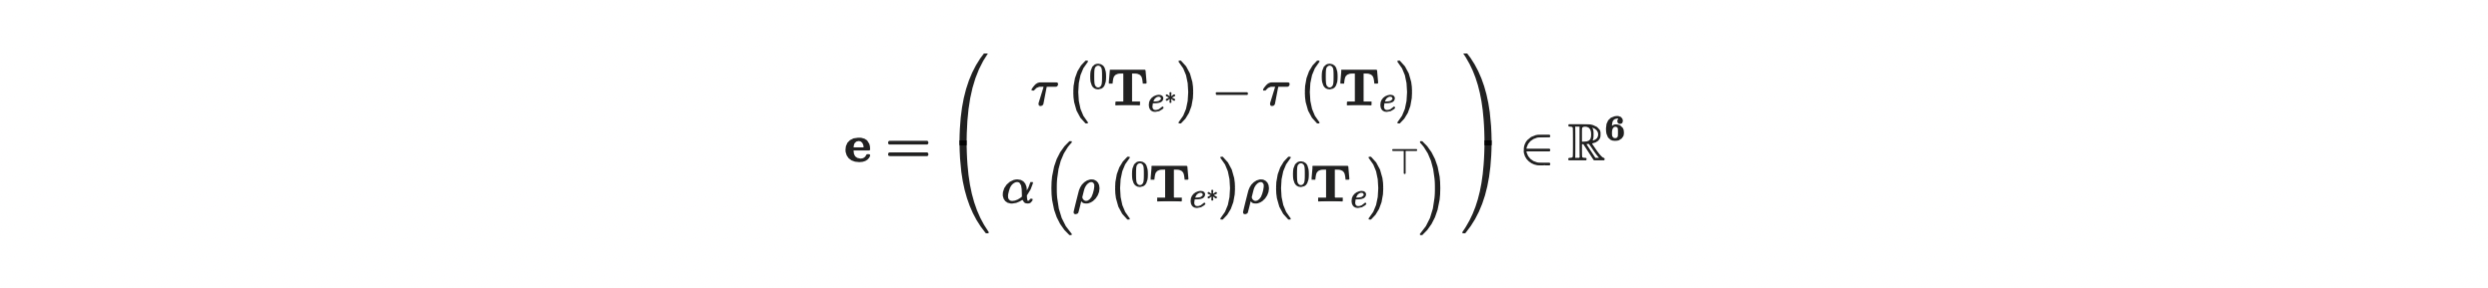



In this equation, $Te$ signifies the forward kinematics of the robot and specifies the end-effector pose relative to the base frame of the robot, while $Te*$ specifies the desired end-effector pose in the robot's base frame.

In [ ]:
#importing neccessary libraries:
import numpy as np
from alpha import alpha
from fk import fk

# error function with desired and current pose parameters
def Err(Ted, Tec):
  # calculates error vector
    Err = np.vstack([(Ted[:-1, -1] - Tec[:-1, -1]).reshape(-1,1),
                 alpha(np.dot(Ted[:3, :3], np.transpose(Tec[:3, :3])))
                ])
    return Err

Now, while both the current and desired translational positions can be simply subtracted to find the error for x, y, z, the same cannot be done for the rotational errors. Due to this, in order to calculate for the rotational error function, we need an alpha function $\alpha$ which acts as the transformation matrix that will convert the rotation matrix to its equivalent Euler vector representation.

To compute $\alpha$, we initially need to determine if the rotation matrix $R$ is diagonal or not. If $R$ is not diagonal, the Euler vector can be obtained as follows,

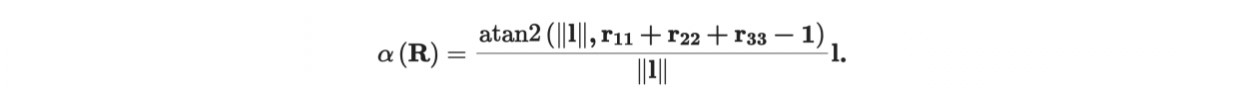

if $R$ is a diagonal, then there are two cases for calculating the Euler vector. The first case is where the diagonal matrix is made up of 1's, also referred to as the identity matrix. If this is the case then,


$$ R = \begin{bmatrix}
1 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 1
\end{bmatrix} $$

\begin{align*}
\alpha(\mathbf{R}) &= \begin{pmatrix} 0 \ 0 \ 0 \end{pmatrix}^T
\end{align*}

Otherwise, if $R$ is a diagonal matrix that is not the identity matrix then,

\begin{align*}
\alpha(\mathbf{R}) &= \frac{\pi}{2}
\begin{bmatrix}
r_{11} + 1 \\
r_{22} + 1 \\
r_{33} + 1
\end{bmatrix}
\end{align*}

To calculate the Euler vector, we need to compute $l$ which represents the axis of rotation encoded in the rotation matrix $R$.The first component of $l$ represents the rotation about the x-axis, the second component is the rotation about the y-axis, and the third component is the rotation about the z-axis.

\begin{align*}
\mathbf{I} &=  
\begin{bmatrix}
r_{32} - r_{23} \\
r_{13} - r_{31} \\
r_{21} - r_{12}
\end{bmatrix}
\end{align*}

In [ ]:
import numpy as np
from isdiag import isdiag
# define the alpha function
def alpha(M): # M is the rotation matrix
    def I(M): # I(M) calculates Euler representation of matrix
        return np.array([[M[2,1] - M[1,2]],
                        [M[0,2] - M[2,0]],
                        [M[1,0] - M[0,1]]])

    A = np.linalg.norm(I(M))
    if A < 1e-6:
       if M[0, 0] == 1 and M[1, 1] == 1 and M[2, 2] == 1:
        alpha = np.array([[0], [0], [0]])
       else:
          alpha = (np.pi / 2) * np.array([[M[0, 0] + 1],
                                        [M[1, 1] + 1],
                                        [M[2, 2] + 1]])
    else:
        B = M[0, 0] + M[1, 1] + M[2, 2] - 1
        alpha = np.dot(np.divide(np.arctan2(A, B),A), I(M))

return alpha

Note: In Python, indexing of elements in arrays, lists, and matrices starts from 0, not 1. This means that the first element of a sequence is accessed using index 0, the second element with index 1, and so on.

#### Quadratic Error Function

The quadratic error function takes the error vector $e$, which defines the differences between the desired and actual end-effector poses, and computes the sum of squared errors across all dimensions. By squaring each element of the error vector and summing them up, the quadratic error function gives us a scalar value to represent a measurement of the overall magnitude and direction of the error. This value is used in the calculations of inverse kinematics which will be covered in the next section of this tutorial.

In [ ]:
def QuadraticError(Ted, Tec):
    we = np.array([1, 1, 1, 0.8, 0.8, 0.8]) # weighting factor
    We = np.diag(we) # diagonal of weighting vector
    E = 0.5 * np.transpose(Err(Ted, Tec)).dot(We).dot(Err(Ted, Tec))
    return E

The weighting vector $we$ plays a crucial role in the calculation of the Quadratic Error function. It allows for the assignment of relative importance or influence to different components of the error vector. Each value in the $we$ vector corresponds to the relative weight assigned to the corresponding dimension of the error vector. In many cases, the first three values in the weighting vector are assigned to the translational components (x, y, and z), while the remaining three values are assigned to the rotational components (roll, pitch, and yaw).By adjusting the values in the $we$ vector, you can prioritize certain dimensions or observations over others during the error calculation process.